In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from astropy.coordinates import solar_system_ephemeris, get_body, get_sun, HeliocentricTrueEcliptic
from astropy.time import Time, TimeDelta

from zodipy import tabulate_density

In [2]:
N = 200
x = np.linspace(-2.5, 2.5, N)  # x-plane
y = np.linspace(-2.5, 2.5, N)  # y-plane
z = np.linspace(-2.5, 2.5, N)  # z-plane

In [3]:
grid = np.asarray(np.meshgrid(x, y, z))
density_grid = tabulate_density(grid, model="dirbe")
density_grid = density_grid.sum(axis=0)  # Sum over all components

In [4]:
start_time = Time("1990-09-22 23:22")
dt = TimeDelta(15, format="jd")
time_range = start_time + dt * np.arange(0, 5*365//30+1)

earth_location = get_body('earth', time_range).transform_to(HeliocentricTrueEcliptic()).cartesian.xyz.to('AU')

In [5]:
planets = ['mercury', 'venus', 'mars']
sun_location = get_sun(time_range).cartesian.xyz.to('AU')
planet_locations = np.stack([get_body(p, time_range).transform_to(HeliocentricTrueEcliptic()).cartesian.xyz.to('AU') for p in planets])

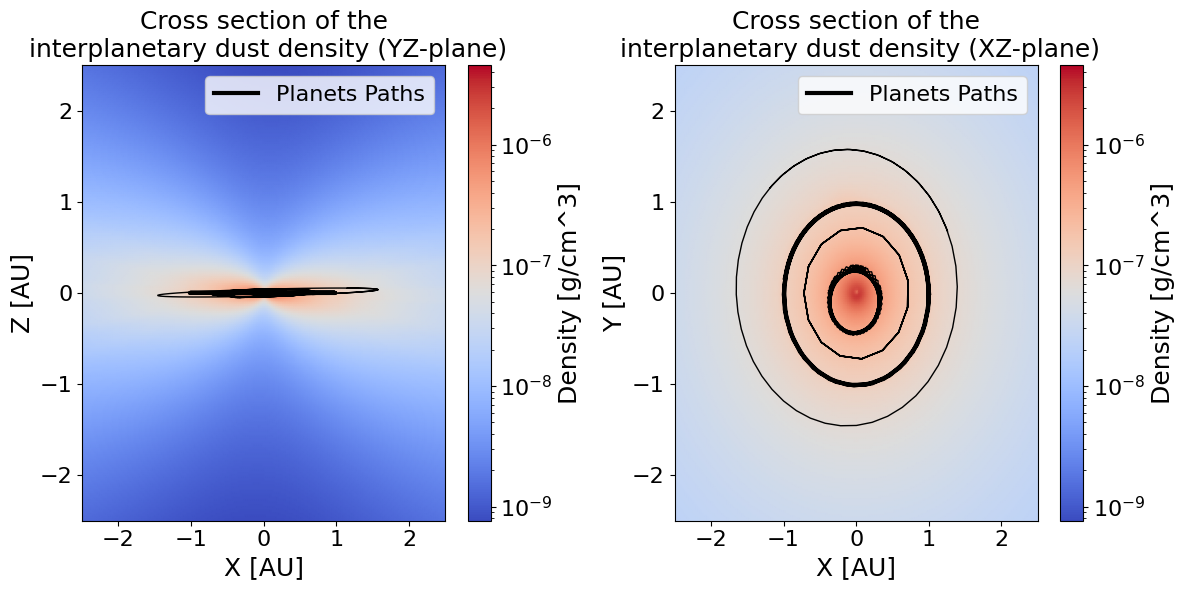

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plt1 = ax1.pcolormesh(
    x,
    y,
    density_grid[N // 2].T,  # cross section in the yz-plane
    cmap="coolwarm",
    norm=LogNorm(vmin=density_grid.min(), vmax=density_grid.max()),
    shading="gouraud",
    rasterized=True
)
ax1.plot(earth_location[1, :], earth_location[2, :], "k", lw=3, label='Planets Paths')
for planet in planet_locations:
    ax1.plot(planet[1, :], planet[2, :], "k", lw=1, label=None)
cbar = fig.colorbar(plt1, ax=ax1)
cbar.set_label("Density [g/cm^3]", fontsize=18)
cbar.ax.yaxis.set_tick_params(labelsize=16)
ax1.set_title("Cross section of the\n interplanetary dust density (YZ-plane)", fontsize=18)
ax1.set_xlabel("X [AU]", fontsize=18)
ax1.set_ylabel("Z [AU]", fontsize=18)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.legend(fontsize=16)
# ax1.axis('equal')

plt2 = ax2.pcolormesh(
    y,
    z,
    density_grid[:, :, N // 2].T,  # cross section in the yz-plane
    cmap="coolwarm",
    norm=LogNorm(vmin=density_grid.min(), vmax=density_grid.max()),
    shading="gouraud",
    rasterized=True
)
ax2.plot(earth_location[0, :], earth_location[1, :], "k", lw=3, label='Planets Paths')
for planet in planet_locations:
    ax2.plot(planet[0, :], planet[1, :], "k", lw=1, label=None)
cbar = plt.colorbar(plt2, ax=ax2)
cbar.set_label("Density [g/cm^3]", fontsize=18)
cbar.ax.yaxis.set_tick_params(labelsize=16)
ax2.set_title("Cross section of the\n interplanetary dust density (XZ-plane)", fontsize=18)
ax2.set_xlabel("X [AU]", fontsize=18)
ax2.set_ylabel("Y [AU]", fontsize=18)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.legend(fontsize=16)
# ax2.axis('equal')
fig.tight_layout()
plt.savefig('../outputs/dust_density.pdf', format='pdf')
plt.show()

In [2]:
# zodiacal light image creation
import astropy.units as u
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time

from zodipy import Zodipy
from zodipol.visualization.skymap_plots import plot_skymap

In [7]:
model = Zodipy("dirbe", solar_cut=30 * u.deg, extrapolate=True, parallel=False)
nside = 256

binned_emission = model.get_binned_emission_pix(
    0.7 * u.micron,
    pixels=np.arange(hp.nside2npix(nside)),
    nside=nside,
    obs_time=Time("2022-06-14"),
    obs="earth",
)

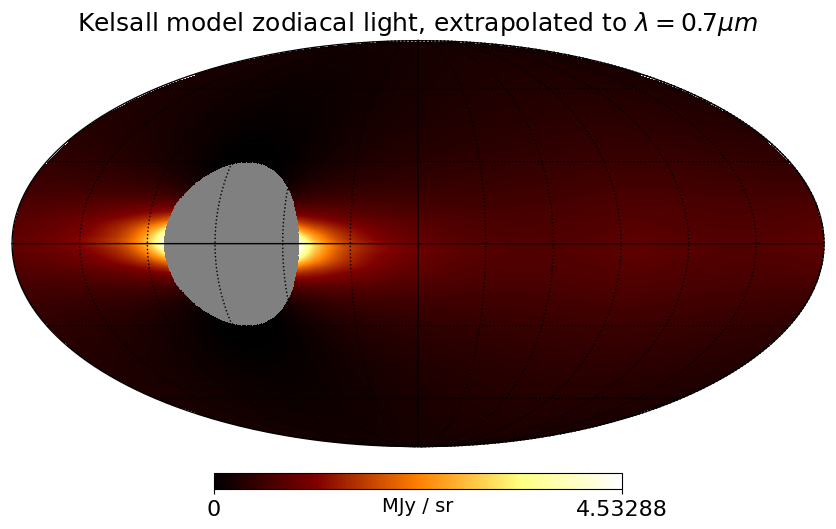

In [8]:
plot_skymap(binned_emission, min=0, title="Kelsall model zodiacal light, extrapolated to $\lambda=0.7\mu m$", saveto='../outputs/kelsall_1250um.pdf')